In [12]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/cloudera/Downloads/big-data-4/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [3]:
df.count()

1587257

In [32]:
filterDF = df.filter((df.rowID % 5) == 0)
filterDF.count()

317452

In [5]:
filterDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102434,3.051716552830638,905.0,929.5
air_temp,158726,61.851589153636304,11.833569210641757,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [6]:
filterDF.filter((filterDF.rain_accumulation) == 0.0).count()

157812

In [7]:
filterDF.filter((filterDF.rain_duration) == 0.0).count()

157237

In [8]:
workingDF = filterDF.drop("rain_accumulation").drop("rain_duration").drop("hpwren_timestamp")

In [9]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [10]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [13]:
features_used = ['air_pressure', 'air_temp','avg_wind_direction','avg_wind_speed','max_wind_direction', 'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols = features_used, outputCol = "features_unscaled")
assembled = assembler.transform(workingDF)

In [15]:
scaler = StandardScaler(inputCol = "features_unscaled", outputCol = "features", withStd = True, withMean = True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [17]:
scaledData = scaledData.select("features", "rowID")
elbowSet = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowSet.persist()

DataFrame[features: vector]

In [18]:
clusters = range(2,31)
wsseList = utils.elbow(elbowSet, clusters)


Training for cluster size 2 
......................WSSE = 114993.13181214454 
Training for cluster size 3 
......................WSSE = 104181.0978581738 
Training for cluster size 4 
......................WSSE = 94577.27151288436 
Training for cluster size 5 
......................WSSE = 87993.46098415818 
Training for cluster size 6 
......................WSSE = 85084.23922296542 
Training for cluster size 7 
......................WSSE = 81664.96024487517 
Training for cluster size 8 
......................WSSE = 78397.76745113655 
Training for cluster size 9 
......................WSSE = 76599.60815784344 
Training for cluster size 10 
......................WSSE = 74023.93930498546 
Training for cluster size 11 
......................WSSE = 72772.61056038193 
Training for cluster size 12 
......................WSSE = 70281.81723912072 
Training for cluster size 13 
......................WSSE = 69473.53243631397 
Training for cluster size 14 
......................WSSE = 68756.123291

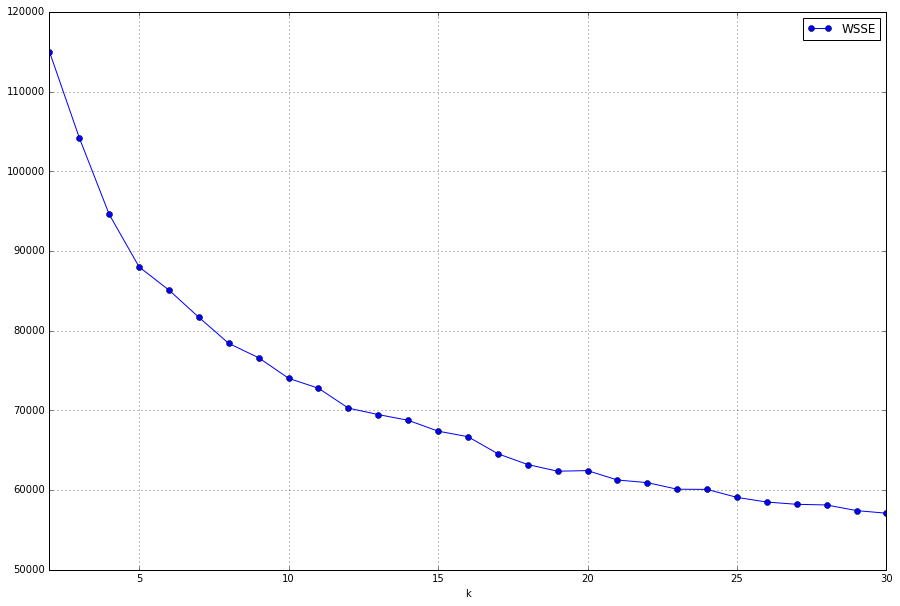

In [19]:
utils.elbow_plot(wsseList,clusters)

In [22]:
ScaleddataFeat = scaledData.select("features") 
ScaleddataFeat.persist()


DataFrame[features: vector]

ScaleddataFeat = scaledData.select("features")
ScaleddataFeat.persist()

In [33]:
kmeans = KMeans(k = 20, seed = 1)
model = kmeans.fit(ScaleddataFeat)
transformed = model.transform(ScaleddataFeat)

In [34]:
centers = model.clusterCenters()
centers

[array([-0.83981371, -0.15722835,  0.45677248,  1.66719716,  0.53773469,
         1.59591307,  0.2320302 ]),
 array([ 1.24855842, -0.97733363, -1.2926491 , -0.5038991 , -1.13732659,
        -0.50899898,  0.42262184]),
 array([-1.836545  , -1.39012854,  0.39879547,  3.16298379,  0.48657869,
         3.10579576,  1.47485229]),
 array([ 0.32897594, -1.09184129,  1.27209305, -0.59060207,  1.55960843,
        -0.52526953,  1.11801273]),
 array([-1.28998389, -1.05895456,  0.36933732,  0.11511323,  0.46356054,
         0.11174136,  1.30954421]),
 array([-0.59270225,  0.65334454,  0.18596774, -0.65062076,  0.35756438,
        -0.66715743, -0.29405518]),
 array([-0.20836792,  1.17097712, -1.33441829, -0.577544  , -1.18073314,
        -0.58597431, -0.84635169]),
 array([ 0.24429517,  0.36916242,  1.89125163, -0.65004271, -1.55350503,
        -0.5758593 , -0.33656513]),
 array([ 0.37340608, -1.11279756,  0.41994128,  0.35183269,  0.49113258,
         0.32578092,  1.16887259]),
 array([ 1.17406259

In [35]:
P = utils.pd_centers(features_used, centers)

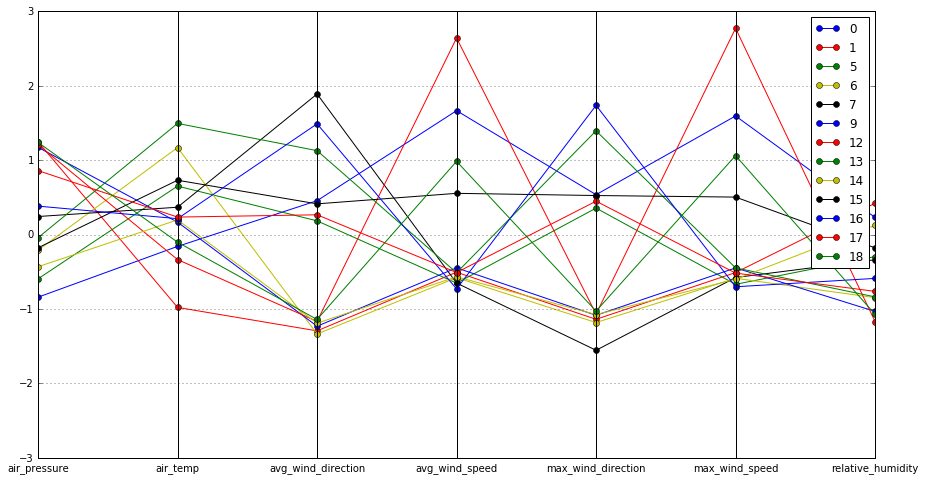

In [36]:
utils.parallel_plot(P[P['relative_humidity'] < 0.5], P)

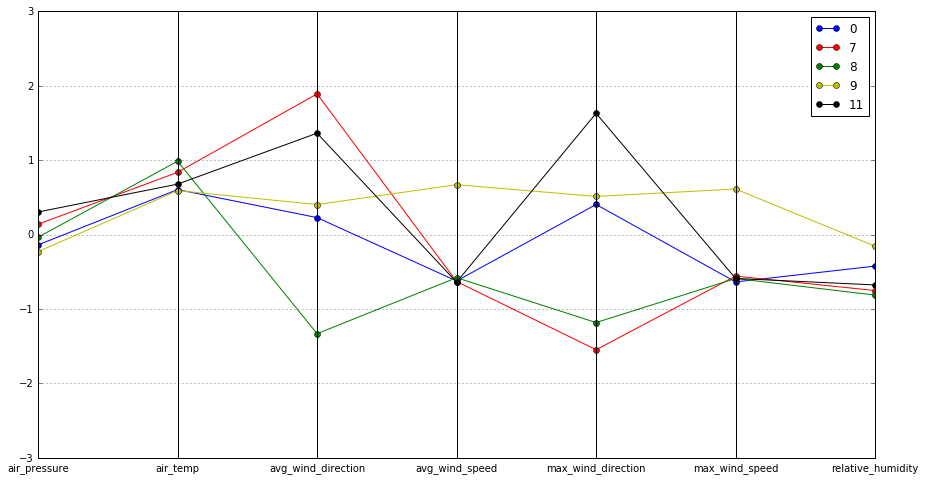

In [28]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

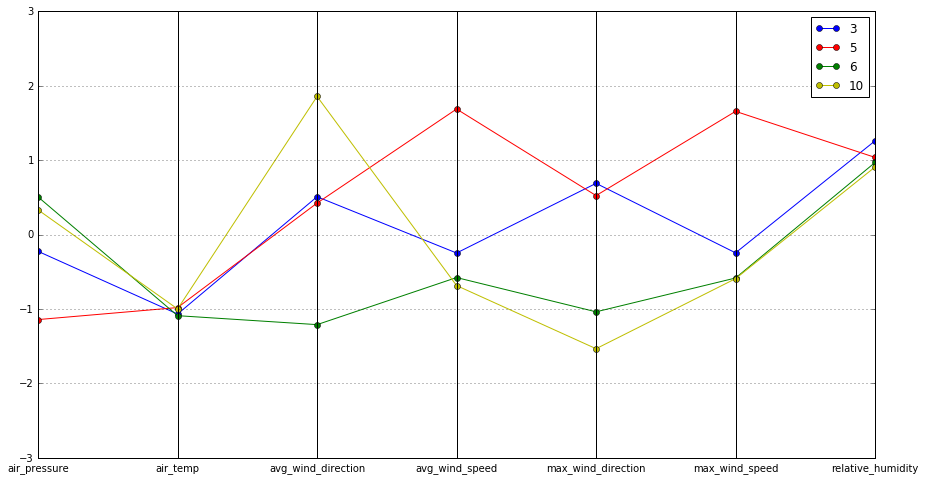

In [30]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

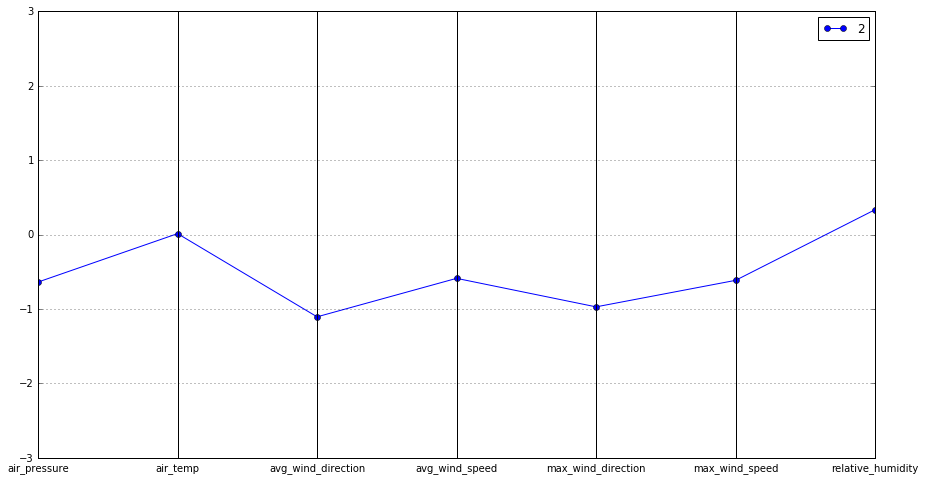

In [31]:
utils.parallel_plot(P.iloc[[2]],P)